#  Cat Boost

The aim of this notebook is to try out XG-boost on our optimization problem. There is also some ideas and concepts that will overlap with other machine learning models. Some novel ideas related to the preprocessing step is in this file, but SHOULD be moved to a dedicated pre-processing library to make the puipeline easier to work with.

*TODO: Create a preprocessing library*

### Import the needed libraries

In [33]:
# First we will extract the data, and save it to a csv.

# Machine Learning Model
import catboost as cb

# Data Processing Tools
import numpy as np
import pandas as pd
import seaborn as sns

# Data Display Tools
import matplotlib.pyplot as plt

# Machine Learning Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline



### Extract data

In [34]:
train_a = pd.read_parquet('A/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')

print(X_train_estimated_a.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17576 entries, 0 to 17575
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date_calc                       17576 non-null  datetime64[us]
 1   date_forecast                   17576 non-null  datetime64[us]
 2   absolute_humidity_2m:gm3        17576 non-null  float32       
 3   air_density_2m:kgm3             17576 non-null  float32       
 4   ceiling_height_agl:m            13657 non-null  float32       
 5   clear_sky_energy_1h:J           17576 non-null  float32       
 6   clear_sky_rad:W                 17576 non-null  float32       
 7   cloud_base_agl:m                15482 non-null  float32       
 8   dew_or_rime:idx                 17576 non-null  float32       
 9   dew_point_2m:K                  17576 non-null  float32       
 10  diffuse_rad:W                   17576 non-null  float32       
 11  di

### Preprocessing of data
Notice that we for now have a whole block dedicated to preprocessing, but should rather be its own module.

TODO: Only train on the daytime data.

TODO: Add a sun asimuth is good enough.

In [35]:
def data_length_matching(train: pd.DataFrame, obs: pd.DataFrame)-> tuple[pd.DataFrame, pd.DataFrame]:
    """
    This function is intended to ensure that both the training data and
    the observed data are sorted, and contain the same number of entries. 
    """

    # Cut the data frames so that their date match.
    obs_feature_test = obs[obs['date_forecast'].isin(train['time'])].sort_values(by=['date_forecast'])  # sortert etter datao
    # If only one of them has the date ensure that the other also has the same sorting.
    train_feature_test = train[train['time'].isin(obs['date_forecast'])].sort_values(by=['time'])       # sortert etter datao

    return train_feature_test, obs_feature_test

X_total = pd.concat([X_train_observed_a, X_train_estimated_a], axis = 0, ignore_index=True)
train_a = train_a.dropna()
y, X = data_length_matching(train_a, X_total)

y = y.reset_index(drop = True)
X = X.reset_index(drop = True)



In [36]:


X['day_of_year'] = X['date_forecast'].dt.dayofyear
X['month'] = X['date_forecast'].dt.month
X['hour'] = X['date_forecast'].dt.hour

X = X.drop('date_forecast', axis=1)
X = X.drop('date_calc', axis=1)
X = X.interpolate(method='linear')
X = X.fillna(method="backfill", axis=None)
y = y.drop('time', axis=1)


# DO we get a day or the 

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()

# Fit and transform the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\isakasa\AppData\Local\Temp\ipykernel_15212\1114314456.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="backfill", axis=None)


## AI Training: CatBoost


In [44]:

train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

model = cb.CatBoostRegressor(loss_function="RMSE", logging_level='Silent')

grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset, verbose=False)


pred = model.predict(X_test)
mae = (mean_absolute_error(y_test, pred))
r2 = r2_score(y_test, pred)
print("Testing performance")
print("Mean Abs: {:.2f}".format(mae))
print("R2: {:.2f}".format(r2))



Testing performance
Mean Abs: 136.75
R2: 0.86


### Plotting
Adding a set of plotts to see how well the machine-learning model performs graphically.

TODO: We should probably plot the data-values that perform the worst.

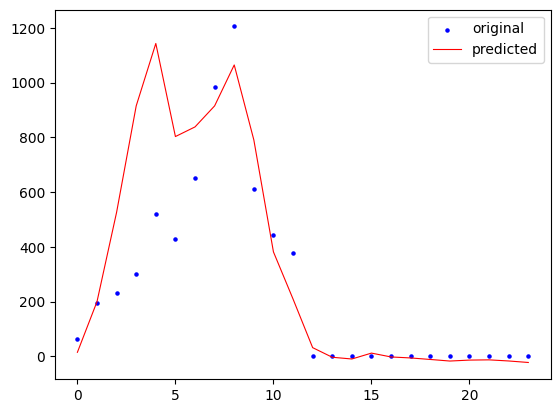

In [47]:


x_ax = range(24)
plt.scatter(x_ax, y_test[0:48], s=5, color="blue", label="original")
plt.plot(x_ax, pred[0:48], lw=0.8, color="red", label="predicted")

plt.legend()
plt.show()
